In [1]:
import numpy as np
import matplotlib.pyplot as plt

import product_fem as pf
import fenics as fx

# Initial setup

First we need to pick a discretized space for spatial coordinates.
Let's use a 15 by 10 node lattice on the unit square and define 
a finite dimensional space of linear continuous Galerkin functions.
Finally we create a `ProductFunctionSpace` on the Cartesian product
of the unit square with itself. A typical basis function in this space
is $\phi_{ij}(x,y) = \phi_i(x) \phi_j(y)$ where $\phi_i$ is a basis function
in $V$.

In [3]:
nx, ny = 15, 10 # mesh resolution
mesh = fx.UnitSquareMesh(nx-1, ny-1)
V = fx.FunctionSpace(mesh, 'CG', 1)
W = pf.ProductFunctionSpace(V)

# Forward problem

Now we make an instance of the spatial coalescence PDE with boundary
$\{ (x,y)\in [0,1]^2 \times [0,1]^2 : \|x-y\| < \epsilon \}$
for some choice of $\epsilon$. For now let's make the boundary value
constant, but we could define a non-constant callable instead if we prefer.

In [4]:
u_bdy = 0.5 # or could be a callable
epsilon = 1e-2
eqn = pf.equations.HittingTimes(W, u_bdy, epsilon)

This instance comes with an initial value of the control,  
which we can get from the equation object. Let's solve and 
plot a slice of the solution.

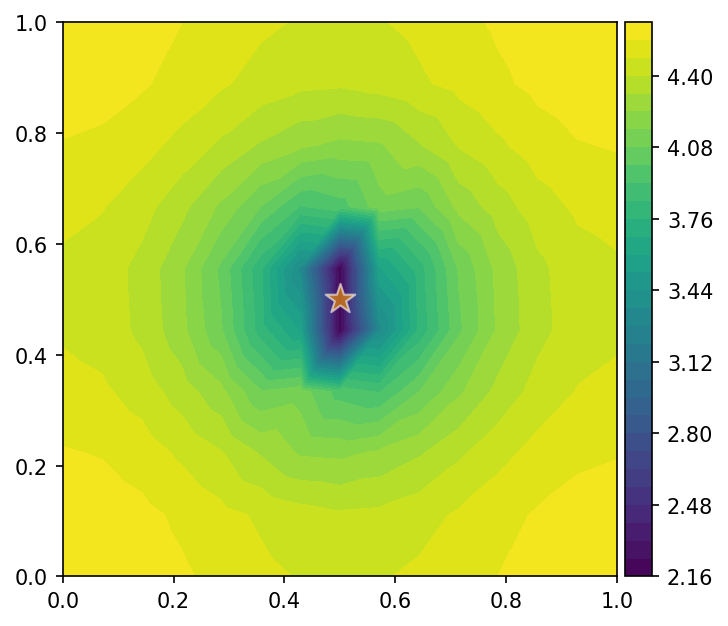

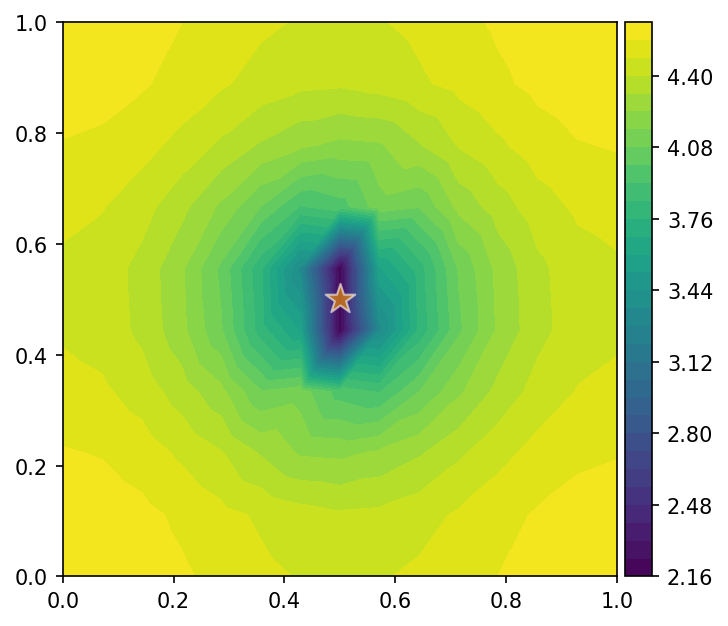

In [5]:
m = eqn.control
m_arr = m.array().copy()
u = eqn.solve(m)
# u = eqn.solve() # solve with initial control
u.plot([0.5, 0.5])

# Loss functional

Next we define an objective function to be minimized under 
the constraint of the forward problem.

$$
    J(u, m; d, \alpha, \beta) = 
        \iint_{\Omega^2}\! (u - d)^2\, dxdy 
        + \frac{\alpha}{2}\int_\Omega\! m \cdot m\,dx 
        + \frac{\beta}{2}\int_\Omega\! \nabla m \cdot \nabla m \,dx
$$

In [6]:
reg = {'l2': [1e-6, 1e-4], 'smoothing': [1e-1, 1e-1]}
J = pf.LossFunctional(u, m, reg)
Jhat = pf.ReducedLossFunctional(eqn, J)
print(Jhat(m)) # loss at truth

4.8045301391819994e-05


In [7]:
def Jhat(m):
    u = eqn.solve(m)
    return J(u, m)

In [8]:
# plot slice of loss surface m + h v for h passing through 0 and arbitrary v
hs = np.linspace(-2.0, 2.0, 10)
v = np.ones(m.dim())
ms = [m_arr + h * v for h in hs]
Js = []

for mi in ms:
    m.update(mi);
    Js.append(Jhat(m))

Krylov solver reached max 10000 iterations
Residual norm is 7.515299726603977
Krylov solver reached max 10000 iterations
Residual norm is 9.79210686281606
Krylov solver reached max 10000 iterations
Residual norm is 16.637590437660556


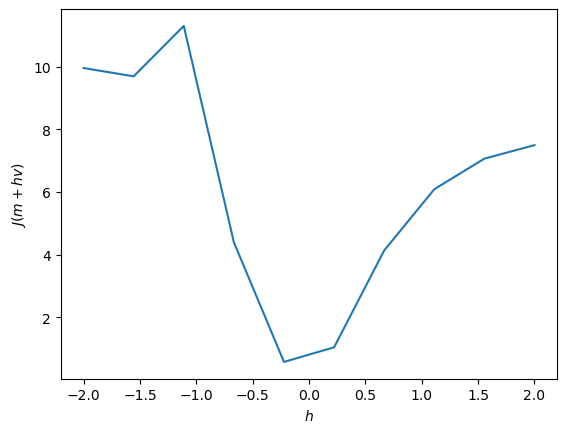

In [9]:
fig, ax = plt.subplots()

ax.plot(hs, Js)
ax.set_xlabel(r'$h$')
ax.set_ylabel(r'$J(m + h v)$')
plt.show()

# Inverse problem

In [10]:
invp = pf.InverseProblem(eqn, loss)

m_hat, results = invp.optimize(m)

NameError: name 'loss' is not defined